## 0. Import needed packages

At first, we need to import all the needed packages

In [30]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow & Keras 
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as tf_backend 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from sklearn.decomposition import PCA

# Import all other needed packages
import scipy.stats as stats
import numpy as np
import math
import csv
from PIL import Image
import random
import os
import json
import pandas as pd
import scipy.linalg as la

# Custom packages
from internal import binarer
from internal.estimaters.main import AccuracyEstimator, sigma_score
from internal.data.csv import CSV

%matplotlib inline

## 1. Sigma score

Our goal is to maximize $\hat{\sigma}_{\text{same}}$ while also maximizing the difference $\hat{\sigma}_{\text{same}}-\hat{\sigma}_{\text{diff}}$ To encapsulate these rules into a single measure, we define the $\Sigma$-score and define it as:
$$
\overline{\Sigma}(\hat{\sigma}_{\text{same}},\hat{\sigma}_{\text{diff}} \mid \epsilon) = (\hat{\sigma}_{\text{same}}-\hat{\sigma}_{\text{diff}})^{1/\eta}\sigma_{\text{same}}
$$

Text(0.5, 0, 'Sigma score')

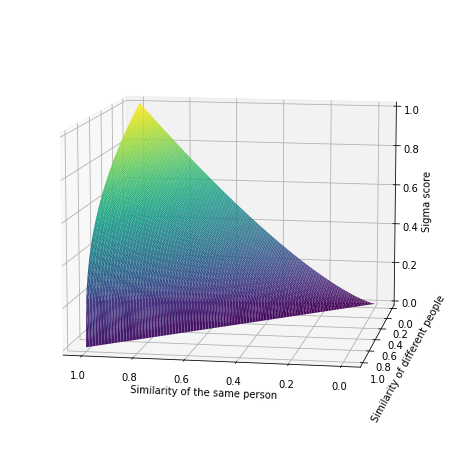

In [3]:
x_values = np.linspace(0, 1, 100)
y_values = np.linspace(0, 1, 100)

X_mesh, Y_mesh = np.meshgrid(x_values, y_values)
Z_mesh = sigma_score(X_mesh, Y_mesh)

plt.figure(figsize=(8,10))
ax = plt.axes(projection='3d')
ax.view_init(10, 100)
ax.plot_surface(X_mesh, Y_mesh, Z_mesh, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Similarity of the same person')
ax.set_ylabel('Similarity of different people')
ax.set_zlabel('Sigma score')

## 2. Load all vectors

CSV file is formatted in the following way:

| entry_id | path_to_image    | person_id | $x_1$    | $x_2$    | $\dots$  | $x_N$    | 
| ---      |  ---             | ---       | ----     | ----     | ----     | -----    |
| 1        | ./images/001.png | 1         | $-0.5$   | $0.4$    | $\dots$  | $-0.25$  |
| 2        | ./images/028.png | 312       | $-0.67$  | $0.23$   | $\dots$  | $0.81$   |
| $\vdots$ | $\vdots$         | $\vdots$  | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |

Where $x_i$ denotes a column of $i$th component of an input vector $\mathbf{x}$

In [5]:
# Loading our dataset
X, Y, links = CSV(input_path='./csv_datasets/face_recognition_celeba.csv').read()

print('Number of vectors (and labels, respectively) is', len(X))

Number of vectors (and labels, respectively) is 196855


## Applying PCA to our dataset

To make sure we have loaded everything properly and get a beatiful image :D

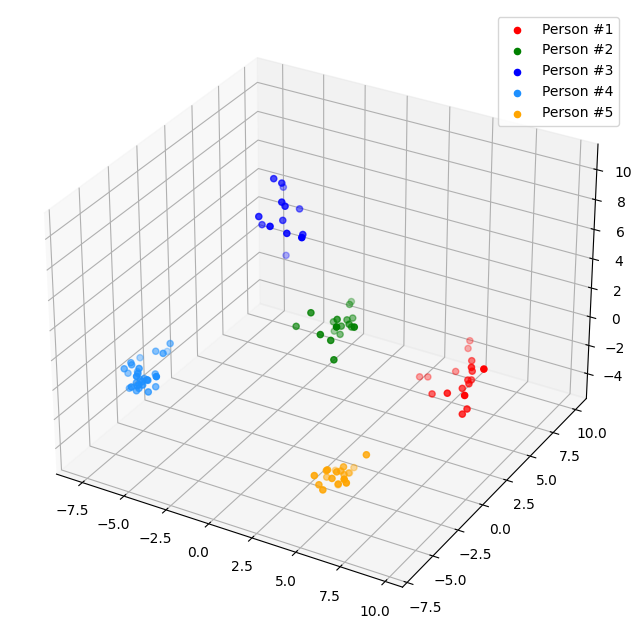

In [6]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

pca = PCA(n_components=3)

batch_1 = [vector for k, vector in enumerate(X) if Y[k] == 10]
color_1 = [1] * len(batch_1)
batch_2 = [vector for k, vector in enumerate(X) if Y[k] == 20]
color_2 = [2] * len(batch_2)
batch_3 = [vector for k, vector in enumerate(X) if Y[k] == 50]
color_3 = [3] * len(batch_3)
batch_4 = [vector for k, vector in enumerate(X) if Y[k] == 21]
color_4 = [4] * len(batch_4)
batch_5 = [vector for k, vector in enumerate(X) if Y[k] == 90]
color_5 = [5] * len(batch_5)

batches = [*batch_1, *batch_2, *batch_3, *batch_4, *batch_5]
colors = [*color_1, *color_2, *color_3, *color_4, *color_5]

batch_scaled = preprocessing.StandardScaler().fit_transform(batches)
pca_features = pca.fit_transform(batch_scaled)

plt.style.use('default')

# Plot scaled features
xdata = pca_features[:,0]
ydata = pca_features[:,1]
zdata = pca_features[:,2]
 
# Plot 3D plot
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

n1 = len(batch_1)
n2 = len(batch_1) + len(batch_2)
n3 = len(batch_1) + len(batch_2) + len(batch_3)
n4 = len(batch_1) + len(batch_2) + len(batch_3) + len(batch_4)
n5 = len(batch_1) + len(batch_2) + len(batch_3) + len(batch_4) + len(batch_5)

ax.scatter3D(xdata[:n1], ydata[:n1], zdata[:n1], c='r', label='Person #1', cmap='jet')
ax.scatter3D(xdata[n1:n2], ydata[n1:n2], zdata[n1:n2], c='g', label='Person #2', cmap='jet')
ax.scatter3D(xdata[n2:n3], ydata[n2:n3], zdata[n2:n3], c='b', label='Person #3', cmap='jet')
ax.scatter3D(xdata[n3:n4], ydata[n3:n4], zdata[n3:n4], c='dodgerblue', label='Person #4', cmap='jet')
ax.scatter3D(xdata[n4:n5], ydata[n4:n5], zdata[n4:n5], c='orange', label='Person #5', cmap='jet')

ax.legend()
#ax.scatter3D(xdata, ydata, zdata, c=colors, cmap='jet')
 
# Plot title of graph

plt.show()

## Binary distance and converting rule

Binary distance is defined as follows:

$$
\delta(\mathbf{x}, \mathbf{y}) = \frac{1}{N}\sum_{k=1}^N |x_j-y_j|
$$

Converting rule is defined as:
$$
\psi(\mathbf{x} \mid \mathbf{t}) := \mathring{\mathbb{I}}(\mathbf{x} > \mathbf{t})
$$

In [7]:
# Check binary distance formula
x = tf.constant([0.0, 0.0, 1.0, 1.0])
print('Vector x is', x)
y = tf.constant([0.0, 0.0, 1.0, 0.0])
print('Vector y is', y)
print('Distance between them is', binarer.binary_distance(x, y))
print('-'*30)

f = tf.constant([1.3, 2.5, -2.3, 0.2, -0.3])
print('Vector f is', f)
print('Converted f given zero vector is', binarer.to_binary_string(f, tf.zeros(shape=(5,))))
print('-'*30)

test_vector = X[100]
print('Now just to test our loaded vectors, let us load some vector from our dataset:', X[100])
print('Converted is', binarer.to_binary_string(test_vector, np.zeros(shape=(128,))))

Vector x is tf.Tensor([0. 0. 1. 1.], shape=(4,), dtype=float32)
Vector y is tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
Distance between them is tf.Tensor(0.25, shape=(), dtype=float32)
------------------------------
Vector f is tf.Tensor([ 1.3  2.5 -2.3  0.2 -0.3], shape=(5,), dtype=float32)
Converted f given zero vector is tf.Tensor([1. 1. 0. 1. 0.], shape=(5,), dtype=float32)
------------------------------
Now just to test our loaded vectors, let us load some vector from our dataset: [-0.10663576  0.10767722 -0.00263303 -0.05884297 -0.18547623  0.11882087
 -0.06442317 -0.12119251  0.10216916 -0.05668224  0.18726218 -0.03251313
 -0.27963877 -0.1144882   0.09311682  0.13558465 -0.07973736 -0.15667976
 -0.16170803 -0.0465467  -0.06281232  0.01414786  0.05444482  0.07000887
 -0.18358861 -0.33582541 -0.07837502 -0.06504025  0.0732218  -0.10319755
 -0.17045775  0.08243161 -0.11960524 -0.04457744  0.01321969  0.06453451
 -0.04788362 -0.07110091  0.24831867  0.04074576 -0.17547256  

2023-02-19 00:52:29.809192: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 00:52:29.811922: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Expected value $\mathbb{E}[X]$
Suppose we have $\{\mathbf{x}_k\}_{k=1}^N$. Then the expected value:
$$
\mathbb{E}(X) \equiv \mu = \frac{1}{N} \sum_{k=1}^N \mathbf{x}_k
$$

In [8]:
expected_value = np.mean(X, axis=0)
print('Expected value is', expected_value)

Expected value is [-0.10458748  0.08706951  0.06313406 -0.06834802 -0.11555941 -0.00979868
 -0.02654224 -0.09836311  0.17026608 -0.08008751  0.18170208 -0.03859668
 -0.24979736 -0.01368936 -0.04673888  0.14272029 -0.15934551 -0.14908355
 -0.08464895 -0.06524961  0.03316814  0.03510629  0.01980594  0.0727367
 -0.1413669  -0.31101325 -0.06332893 -0.08184028  0.01281158 -0.10200401
  0.01932193  0.07472957 -0.18369906 -0.02141437  0.02411318  0.09859298
 -0.04340459 -0.09916782  0.18464858  0.00860688 -0.20341156 -0.0178978
  0.06312869  0.25923566  0.20323607 -0.0043442   0.02068386 -0.07309168
  0.12926551 -0.28091628  0.04385916  0.15405813  0.08311727  0.07087128
  0.07878043 -0.17088928  0.02651652  0.13531725 -0.18804385  0.06249529
  0.06163731 -0.0891576  -0.01549824 -0.07037112  0.1961034   0.10033608
 -0.12160869 -0.14259897  0.1670615  -0.15974705 -0.04638151  0.09949948
 -0.11331245 -0.18660063 -0.26002088  0.02392384  0.38388648  0.14962179
 -0.15760351  0.03222013 -0.0746737

## Forming set of pairs

Set of similar pairs $\mathcal{P}_{\text{same}}$ would be formed by simply taking adjacent pairs in a batch of images in the same class $\mathbf{}$

Set of different pairs $\mathcal{P}_{\text{diff}}$ would be formed by taking $i$th element from batches $j$ and $j+1$

At first, let us form set of batches

## Calculating same similarity
Suppose we have $\mathcal{B} = \{B_1, B_2, \dots, B_M\}$ a set of batches with the same classes

Then, we evaluate same similarity as:
$$
\hat{\sigma}_{\text{same}} = \frac{\sum_{B \in \mathcal{B}} \sum_{j=1}^{|B|-1}\delta(\psi(B_j\mid \mu),\psi(B_{j+1}\mid\mu))}{\sum_{B \in \mathcal{B}} (|B|-1)}
$$

And different similarity as:
$$
\hat{\sigma}_{\text{diff}} = \frac{\sum_{i=1}^{|\mathcal{B}|-1}\sum_{j=1}^{\min\{|B_j|,|B_{j+1}|\}} \delta(\psi(B_{i,j}\mid\mu),\psi(B_{i+1,j}\mid\mu))}{\sum_{j=1}^{|\mathcal{B}|-1}\min\{|B_j|,|B_{j+1}|\}}
$$

## Calculate Sigma score and draw everything beautifully :)

In [8]:
# Defining converter using zero vector
converter_0 = lambda x: binarer.to_binary_string(x, np.zeros(shape=(128,)))
# Defining converter using expectation value
converter_E = lambda x: binarer.to_binary_string(x, expected_value)

estimator = AccuracyEstimator(X, Y)

sigma_same_0, sigma_diff_0, score_0 = estimator.estimate(converter_0)
sigma_same_E, sigma_diff_E, score_E = estimator.estimate(converter_E)

data = [['Zero vector', sigma_same_0[0], sigma_same_0[1], sigma_diff_0[0], sigma_diff_0[1], score_0],
        ['Expected value', sigma_same_E[0], sigma_same_E[1], sigma_diff_E[0], sigma_diff_E[1], score_E]]
pd.DataFrame(data, columns=["Threshold type", "Sigma same", "# of same pairs", "Sigma diff", "# of diff pairs", "Sigma score"])

,Threshold type,Sigma same,# of same pairs,Sigma diff,# of diff pairs,Sigma score
0,Zero vector,"tf.Tensor(0.8899603, shape=(), dtype=float32)",186682,"tf.Tensor(0.8024697, shape=(), dtype=float32)",139481,0.039563
1,Expected value,"tf.Tensor(0.7448473, shape=(), dtype=float32)",186682,"tf.Tensor(0.5286826, shape=(), dtype=float32)",139481,0.140734
